In [1]:
!pip install inference inference-gpu supervision opencv-python
!pip install git+https://github.com/roboflow/sports.git

  Using cached supervision-0.24.0-py3-none-any.whl.metadata (14 kB)
  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached aiortc-1.9.0-cp38-abi3-win_amd64.whl.metadata (5.6 kB)
  Using cached APScheduler-3.10.1-py3-none-any.whl.metadata (5.7 kB)
  Using cached Cython-3.0.0-cp311-cp311-win_amd64.whl.metadata (3.2 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached fastapi-0.110.3-py3-none-any.whl.metadata (24 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Using cached piexif-1.1.3-py2.py3-none-any.whl.metadata (3.7 kB)
  Using cached pillow-10.4.0-cp311-cp311-win_amd64.whl.metadata (9.3 kB)
  Using cached prometheus_fastapi_instrumentator-6.0.0-py3-none-any.whl.metadata (13 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached rich-13.5.2-py3-none-any.whl.metadata (18 kB)
  Using cached supervision-0.22.0-py3-none-any.whl.metadata (13 kB)
  Using cach


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Cloning https://github.com/roboflow/sports.git to c:\users\isss1\appdata\local\temp\pip-req-build-purxh4qf
  Resolved https://github.com/roboflow/sports.git to commit 06053616f1f8a8ae1fa936eb00dcdc2e4f888bb1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached transformers-4.46.2-py3-none-any.whl.metadata (44 kB)
  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
  Using cached scikit_learn-1.5.2-cp311-cp311-win_amd64.whl.metadata (13 kB)
  Using cached sentencepiece-0.2.0-cp311-cp311-win_amd64.whl.metadata (8.3 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
     ---------------------------------------- 0.0/41.5 kB ? eta -:--:--
     ---------------------------- --------- 30.7/41.5 kB 435.7 kB/s eta 0:00:01
     -------------------------------------- 41.5/41.5 kB 505.0 kB/s eta 0:00:00
  Using cached safetensors-0.4.5-

  Running command git clone --filter=blob:none --quiet https://github.com/roboflow/sports.git 'C:\Users\isss1\AppData\Local\Temp\pip-req-build-purxh4qf'

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 0.0/2.7 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.7 GB 2.6 MB/s eta 0:17:02
     ---------------------------------------- 0.0/2.7 GB 4.5 MB/s eta 0:10:05
     ---------------------------------------- 0.0/2.7 GB 4.8 MB/s eta 0:09:19
     ---------------------------------------- 0.0/2.7 GB 4.7 MB/s eta 0:09:40
     ---------------------------------------- 0.0/2.7 GB 5.2 MB/s eta 0:08:38
     ---------------------------------------- 0.0/2.7 GB 5.5 MB/s eta 0:08:09
     ---------------------------------------- 0.0/2.7 GB 5.7 MB/s eta 0:07:56
     ---------------------------------------- 0.0/2.7 GB 6.0 MB/s eta 0:07:31
     ---------------------------------------- 0.0/2.7 GB 6.1 MB/s eta 0:07:25
     ---------------------------------------- 0.0/2.7 GB 6.2 MB/s eta 0:07:16
     ---------------------------------------- 0.0/2.7 GB 6.2 MB/s eta 0:07:15
     -------


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     --------------------- ------------------ 1.4/2.7 GB 5.0 MB/s eta 0:04:15
     --------------------- ------------------ 1.4/2.7 GB 5.0 MB/s eta 0:04:14
     --------------------- ------------------ 1.4/2.7 GB 5.0 MB/s eta 0:04:14
     --------------------- ------------------ 1.4/2.7 GB 5.0 MB/s eta 0:04:14
     --------------------- ------------------ 1.4/2.7 GB 4.9 MB/s eta 0:04:16
     --------------------- ------------------ 1.4/2.7 GB 4.9 MB/s eta 0:04:20
     --------------------- ------------------ 1.4/2.7 GB 4.7 MB/s eta 0:04:26
     --------------------- ------------------ 1.4/2.7 GB 4.7 MB/s eta 0:04:28
     --------------------- ------------------ 1.4/2.7 GB 4.7 MB/s eta 0:04:30
     --------------------- ------------------ 1.4/2.7 GB 4.7 MB/s eta 0:04:28
     --------------------- ------------------ 1.4/2.7 GB 4.6 MB/s eta 0:04:32
     --------------------- ------------------ 1.4/2.7 GB 4.6 MB/s eta 0:04:33
     --------------------- ------------------ 1.4/2.7 GB 4.6 MB

In [4]:
!pip uninstall torch

^C


In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [4]:
!nvidia-smi

Sat Nov  9 14:30:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.09                 Driver Version: 561.09         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   53C    P8             N/A /  115W |     927MiB /   8188MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import torch
import cv2
import supervision as sv
from IPython.display import clear_output

if torch.cuda.is_available():
    print("CUDA is available. Training on GPU!")
else:
    print("CUDA is not available. Training on CPU.")
    
!nvcc --version

CUDA is available. Training on GPU!
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [2]:
import numpy as np

class ViewTransformer:
    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        if source.shape != target.shape:
            raise ValueError(
                "Source and target must have the same shape.")
        if source.shape[1] != 2:
            raise ValueError(
                f"Source and target points must be 2D coordinates. They are currently {source.shape} and {target.shape}.")

        source = source.astype(np.float32)
        target = target.astype(np.float32)

        self.m, _ = cv2.findHomography(source, target)
        if self.m is None:
            raise ValueError(
                "Homography matrix could not be calculated.")

    def transformPoints(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        if points.shape[1] != 2:
            raise ValueError("Points must be 2D coordinates.")

        points = points.reshape(-1, 1, 2).astype(np.float32)
        points = cv2.perspectiveTransform(points, self.m)
        
        return points.reshape(-1, 2).astype(np.float32)

In [3]:
from sports.configs.soccer import SoccerPitchConfiguration
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch
import supervision as sv
from inference import get_model
import numpy as np
import cv2

BALL_CLASS_ID = 0
GOALKEEPER_CLASS_ID = 1
PLAYER_CLASS_ID = 2
REFEREE_CLASS_ID = 3

SOCCER_PITCH_CONFIG = SoccerPitchConfiguration()
PITCH_CONFIDENCE_LEVEL = 0.7
KEYPOINT_CONFIDENCE_LEVEL = 0.6
OBJECT_DETECTION_MODEL_NAME = "soccer-computer-vision-acffy/3"

# TODO: Change this to my model when I revise it, and include 36 keypoints
KEYPOINT_DETECTION_MODEL_NAME = "football-field-detection-f07vi/15"

# Setting the models as global variables so that they're not repeatedly called
keypointModel = get_model(model_id=KEYPOINT_DETECTION_MODEL_NAME)
objectModel = get_model(model_id=OBJECT_DETECTION_MODEL_NAME)

# Common functionality to be run on soccer frames
class SoccerFrame:
    def __init__(self, image) -> None:
        self.image = image.copy()
        self.objectDetections = self.makeObjectDetections()
        self.keypoints = self.obtainKeypoints()
        self.transformer = self.createTransformer()
    
    def makeObjectDetections(self):
        result = objectModel.infer(self.image, confidence=0.3)[0]
        objectDetections = sv.Detections.from_inference(result)
        
        return objectDetections

    # Uses a keypoint detection model to return pitch keypoints
    def getPitchKeypoints(self):
        result = keypointModel.infer(self.image, confidence=PITCH_CONFIDENCE_LEVEL)[0]    
        
        return sv.KeyPoints.from_inference(result)
        
    # Returns filtered keypoints
    def obtainKeypoints(self):
        keypoints = self.getPitchKeypoints()
        

        self.filter = self.getKeypointsFilter(keypoints)
        xy = keypoints.xy[self.filter]
        confidence = keypoints.confidence[self.filter]
        
        return sv.KeyPoints(xy=xy[np.newaxis, ...], confidence=confidence[np.newaxis, ...])
        
    def getKeypointsFilter(self, keypoints):
        filter = keypoints.confidence > KEYPOINT_CONFIDENCE_LEVEL
        
        return filter

    # Takes a set of actual and target keypoints, compares them and returns the Homography matrix
    def createTransformer(self):
        source = self.keypoints.xy[0]
        target = np.array(SOCCER_PITCH_CONFIG.vertices)[self.filter[0]]
        
        return ViewTransformer(source=source, target=target)

    def getObjectClassDetections(self, classId):
        return self.objectDetections[self.objectDetections.class_id == classId]

    def getCoordsFromDetections(self):
        return self.objectDetections.get_anchors_coordinates(anchor=sv.Position.CENTER)

    def getPitchTransformedCoords(self, classDetections):
        return self.transformer.transformPoints(points=classDetections.get_anchors_coordinates(anchor=sv.Position.CENTER))

    def getClassCoords(self, classId):
        classDetections = self.getObjectClassDetections(classId)
        classCoords = self.getPitchTransformedCoords(classDetections)
        
        return classCoords

    def getAnnotatedImageWithSpecifiedCoords(self, image, coords, faceColor, edgeColor):
        return draw_points_on_pitch(
            config=SOCCER_PITCH_CONFIG,
            xy=coords,
            face_color=faceColor,
            edge_color=edgeColor,
            radius=8,
            thickness=1,
            pitch=image
        )

    # Takes object detections and annotates the footage
    # Keypoint detections are optional, and will not be rendered if they're not passed
    def getAnnotatedFootage(self, isTracked=False):
        frame = self.image.copy()
        
        # Output detections image, with keypoints and object detection
        boundingBoxAnnotator = sv.BoxAnnotator()
        labelAnnotator = sv.LabelAnnotator()
        
        if isTracked:
            objectLabels = [ f"#{trackerId} {confidence:.2f}" for trackerId, confidence in zip(self.objectDetections.tracker_id, self.objectDetections.confidence) ]
        else: 
            objectLabels = [ f"{className} {confidence:.2f}" for className, confidence in zip(self.objectDetections['class_name'], self.objectDetections.confidence) ]
        
        annotatedFrame = boundingBoxAnnotator.annotate(scene=frame, detections=self.objectDetections)
        annotatedFrame = labelAnnotator.annotate(scene=annotatedFrame, detections=self.objectDetections, labels=objectLabels)

        # Plotting all available keypoints, but showing their confidence levels
        if self.keypoints:
            keypointAnnotator = sv.VertexAnnotator(radius=12, color=sv.Color.GREEN)
            annotatedFrame = keypointAnnotator.annotate(annotatedFrame, self.keypoints)
        
        return annotatedFrame


    def getAnnotatedPitch(self):    
        # Transforming detections for the homography matrix
        ballCoords = self.getClassCoords(BALL_CLASS_ID)
        goalkeeperCoords = self.getClassCoords(GOALKEEPER_CLASS_ID)
        playerCoords = self.getClassCoords(PLAYER_CLASS_ID)
        refereeCoords = self.getClassCoords(REFEREE_CLASS_ID)
        
        pitchImage = draw_pitch(SOCCER_PITCH_CONFIG)
        
        annotatedPitch = self.getAnnotatedImageWithSpecifiedCoords(pitchImage, ballCoords, sv.Color.WHITE, sv.Color.BLACK)
        annotatedPitch = self.getAnnotatedImageWithSpecifiedCoords(annotatedPitch, goalkeeperCoords, sv.Color.GREEN, sv.Color.BLACK)
        annotatedPitch = self.getAnnotatedImageWithSpecifiedCoords(annotatedPitch, playerCoords, sv.Color.BLUE, sv.Color.BLACK)
        annotatedPitch = self.getAnnotatedImageWithSpecifiedCoords(annotatedPitch, refereeCoords, sv.Color.YELLOW, sv.Color.BLACK)
        
        height = annotatedPitch.shape[0]
        width = annotatedPitch.shape[1]
        
        return cv2.resize(annotatedPitch, (width, height))

    def annotatedFootageCallback(self):
        return self.getAnnotatedFootage(isTracked=False)

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [ ]:
# Stores all frames of the video and has the ability to create annotated videos
class SoccerVideo:
    def __init__(self, path) -> None:
        self.path = path
        self.tracker = sv.ByteTrack()
        self.soccerFrames = self.createSoccerFrames()

    # Creates all the soccer frames with soccer frames object
    def createSoccerFrames(self):
        soccerFrames = []
        
        for frame in sv.get_video_frames_generator(source_path=self.path):
            soccerFrames.append(SoccerFrame(frame))
            
        return soccerFrames
            
    # Creates annotated footage video
    def createAnnotatedFootageVideo(self, targetPath):
        dimensions = self.getImageDimensions(self.soccerFrames[0].getAnnotatedFootage())
        output=cv2.VideoWriter(targetPath, -1, 30, dimensions)

        for frame in self.soccerFrames:
            output.write(frame.annotatedFootageCallback())
            
        self.releaseVideo(output)
            
    # Creates annotated pitch video
    def createAnnotatedPitchVideo(self, targetPath):
        dimensions = self.getImageDimensions(self.soccerFrames[0].getAnnotatedPitch())
        
        output=cv2.VideoWriter(targetPath, -1, 30, dimensions)

        for frame in self.soccerFrames:
            output.write(frame.getAnnotatedPitch())
            
        self.releaseVideo(output)
        
    def getImageDimensions(self, image):
        return (image.shape[1], image.shape[0])
    
    # Complete video creation and release resources
    def releaseVideo(self, output):
        cv2.destroyAllWindows()
        output.release()

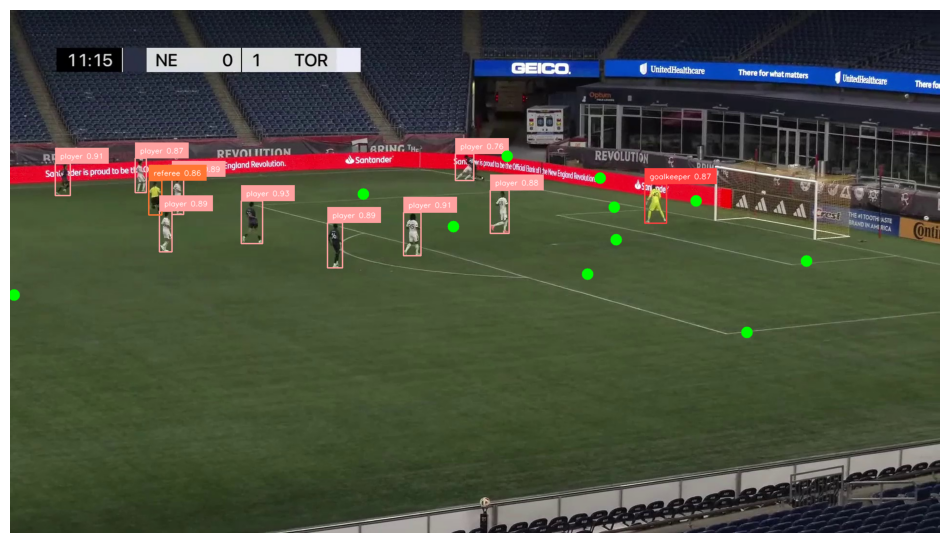

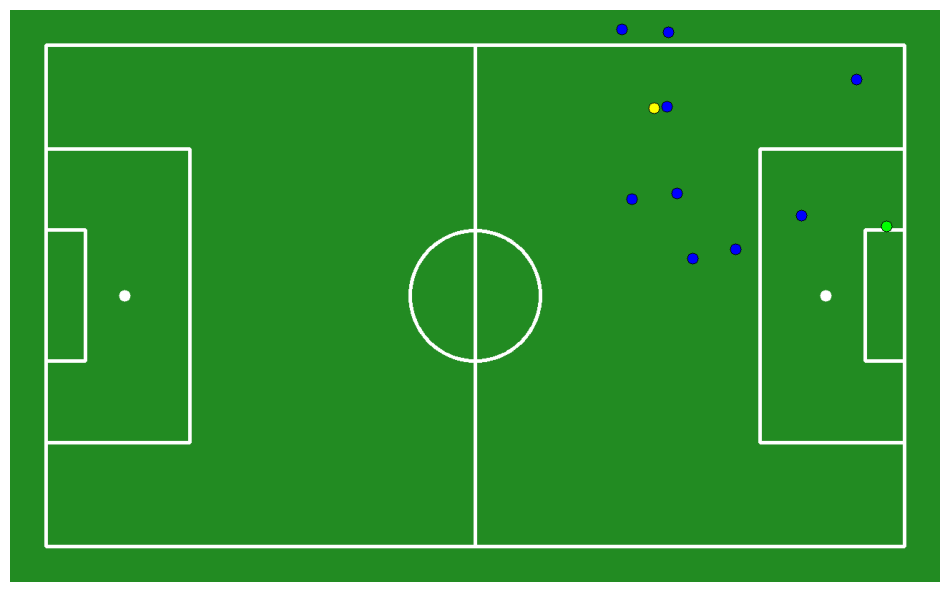

In [12]:
# Perspective transformation
fileName = "images-pitch/frame90.jpg"
image = cv2.imread(fileName)

exampleFrame = SoccerFrame(image)

sv.plot_image(exampleFrame.annotatedFootageCallback())
sv.plot_image(exampleFrame.getAnnotatedPitch())

In [22]:
print("Computing frames...")
exampleVideo = SoccerVideo('soccerClipFootage.mp4')
print("Finished computing frames.")

print("Creating annotated footage video...")
exampleVideo.createAnnotatedFootageVideo('annotated-footage/annotated-footage.mp4')
print("Finished creating video.")

print("Creating annotated pitch video...")
exampleVideo.createAnnotatedPitchVideo('annotated-footage/annotated-pitch.mp4')
print("Finished creating video.")

Computing frames...
(1080, 1920, 3)
Finished computing frames.
Creating annotated footage video...
Finished creating video.
Creating annotated pitch video...
Finished creating video.
